In [1]:
pip install obspy numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Trace count: 3073
Sampling rate: 83333.33 Hz


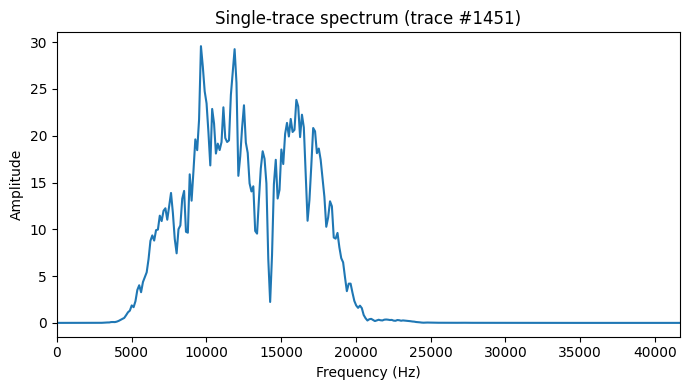

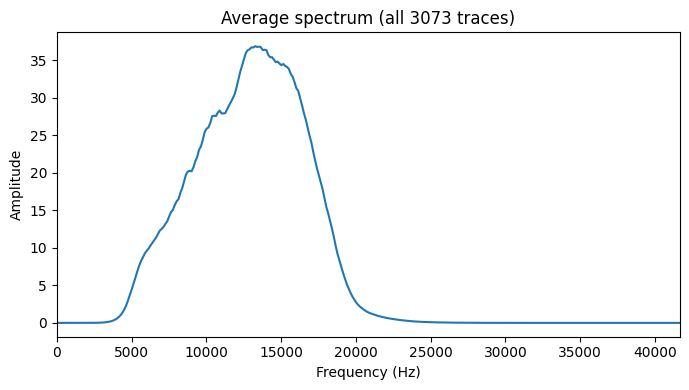

In [4]:
# pip install obspy numpy scipy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from obspy.io.segy.segy import _read_segy

# ===== 1) 读取 SEG-Y =====
SEGY_PATH = "processed/18_bp_5k_20k.sgy"  # ← 改成你的文件路径
sf = _read_segy(SEGY_PATH, headonly=False)
print("Trace count:", len(sf.traces))

# 采样间隔 -> 采样率（做兜底）
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0: return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0: return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in header; use fallback {fallback_ms} ms.")
    return fallback_ms

dt_ms = get_dt_ms(sf)
fs = 1000.0 / dt_ms   # Hz
print(f"Sampling rate: {fs:.2f} Hz")

# 自适应 welch：确保 noverlap < nperseg 且 nperseg <= N
def welch_amp(x, fs, target_nperseg=2048, overlap_ratio=0.5):
    x = np.asarray(x, float)
    x = x - np.mean(x)
    N = len(x)
    nperseg = int(min(target_nperseg, N))
    # 至少 8 点以避免极端短窗
    nperseg = max(nperseg, 8)
    noverlap = int(nperseg * overlap_ratio)
    # 强制 noverlap < nperseg
    if noverlap >= nperseg:
        noverlap = max(0, nperseg - 1)
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=noverlap)
    amp = np.sqrt(Pxx)  # 幅度谱
    return f, amp

# ===== 2) 单道频谱 =====
trace_idx = 1450  # 想看的道号（从 0 开始）
tr = sf.traces[trace_idx].data
f1, A1 = welch_amp(tr, fs, target_nperseg=2048, overlap_ratio=0.5)

plt.figure(figsize=(7,4))
plt.plot(f1, A1)
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"Single-trace spectrum (trace #{trace_idx+1})")
plt.tight_layout()
plt.show()

# ===== 3) 全道平均频谱（更稳，用来定 band-pass）=====
amps = []
# 如果数据很多，可改成取样：for i in range(0, len(sf.traces), 5):
for i in range(len(sf.traces)):
    xi = sf.traces[i].data
    f_avg, Ai = welch_amp(xi, fs, target_nperseg=2048, overlap_ratio=0.5)
    amps.append(Ai)
A_avg = np.sqrt(np.mean(np.array(amps), axis=0)**2)  # 平均功率再开方

plt.figure(figsize=(7,4))
plt.plot(f_avg, A_avg)
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"Average spectrum (all {len(sf.traces)} traces)")
plt.tight_layout()
plt.show()

## save bandpass

In [3]:
# pip install obspy segyio numpy scipy
import os, numpy as np, segyio
from obspy.io.segy.segy import _read_segy
from scipy.signal import butter, sosfiltfilt

src = "MMT(2015)_sgy/X-18_20150928_135813_RAW_LF.sgy"                               # ← 改成你的源文件
dst = "processed/18_bp_5k_20k.sgy"          # 目标文件（会新建）
os.makedirs(os.path.dirname(dst), exist_ok=True)

# 1) 读入（ObsPy 支持变长道）
sf = _read_segy(src, headonly=False)
n_tr = len(sf.traces)

# 采样间隔（微秒）
dt_us = sf.binary_file_header.sample_interval_in_microseconds
if not dt_us or dt_us <= 0:
    # 兜底：从第一条道的 stats 读取（单位: 秒）
    dt_us = int(sf.traces[0].stats.delta * 1e6)

fs  = 1e6 / dt_us
nyq = fs / 2

# 2) 组 2D 数组并补零到同一长度
lengths = [tr.data.size for tr in sf.traces]
ns_max  = max(lengths)
data    = np.zeros((ns_max, n_tr), dtype=np.float32)
for i, tr in enumerate(sf.traces):
    d = tr.data.astype(np.float32)
    data[:d.size, i] = d

# 3) 设计带通并滤波（对每列=每道做零相位滤波）
f_low, f_high = 5000.0, 20000.0
f1 = max(1.0,  min(f_low,  nyq*0.95))
f2 = max(f1*1.05, min(f_high, nyq*0.95))
sos = butter(4, [f1/nyq, f2/nyq], btype="band", output="sos")

# 某些很短的道可能不够 filtfilt 的 padlen，这里做保护
def safe_bp(x):
    try:
        return sosfiltfilt(sos, x, axis=0)
    except Exception:
        # 遇到极短道：退化为单向滤波，避免崩溃
        from scipy.signal import sosfilt
        return sosfilt(sos, x, axis=0)

data_bp = safe_bp(data)

# 4) 写成新的定长 SEG-Y（注意 from_array 需要形状 (n_traces, ns)）
segyio.tools.from_array(dst, data_bp.T, dt=int(dt_us))
with segyio.open(dst, "r+") as f:
    f.text[0] = segyio.tools.wrap(
        f"BANDPASS {int(f1)}–{int(f2)} Hz via sosfiltfilt; padded to ns={ns_max}"
    )

print("Done ->", dst)

Done -> processed/18_bp_5k_20k.sgy


/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


## Apply bandpass filtering

Trace count: 2481, fs = 83333.3 Hz, Nyquist = 41666.7 Hz


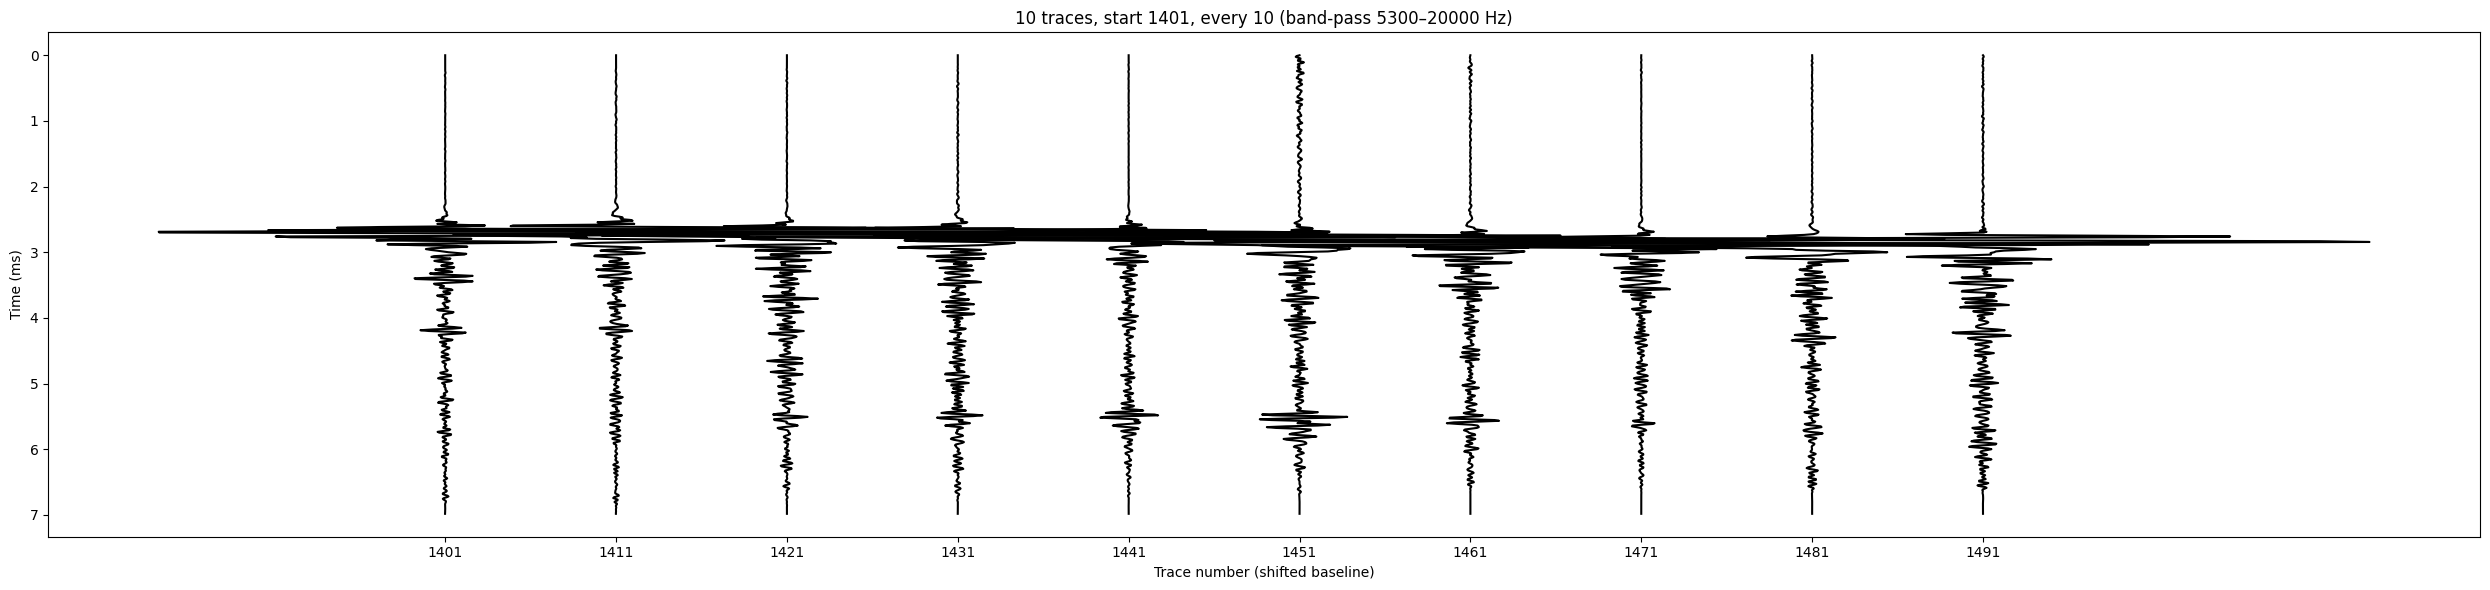

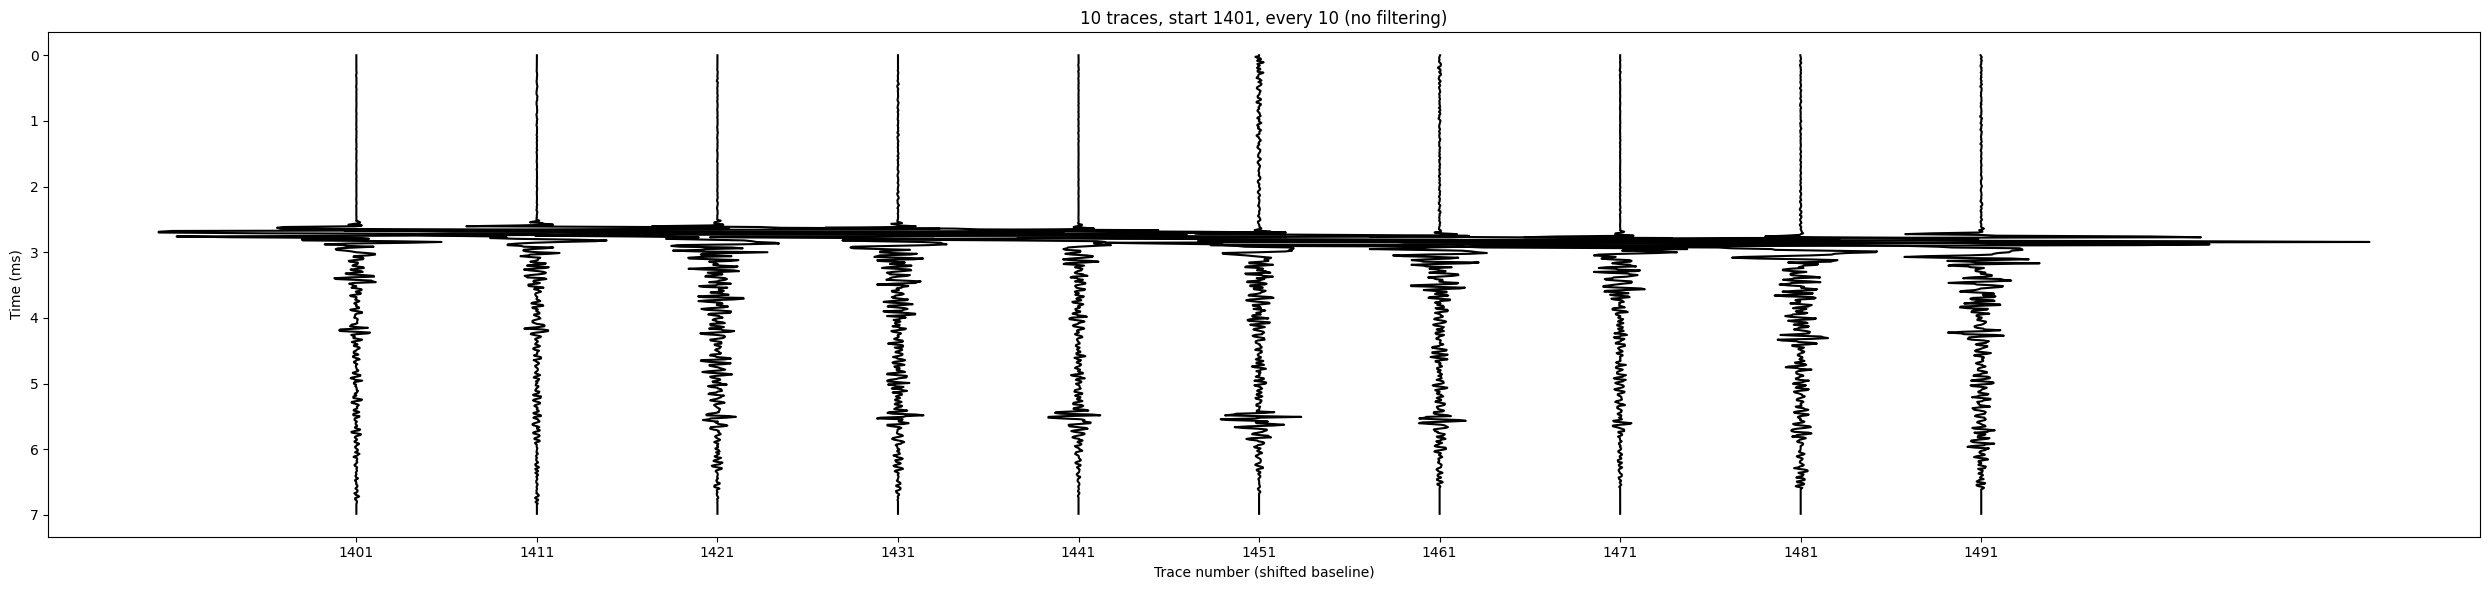

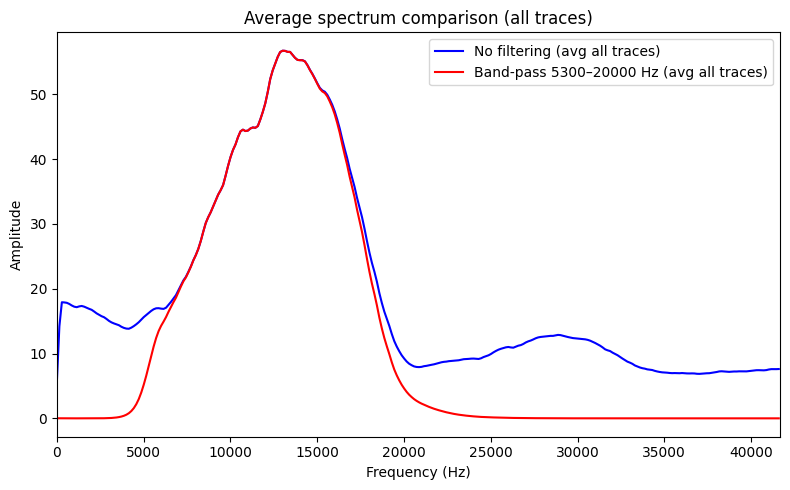

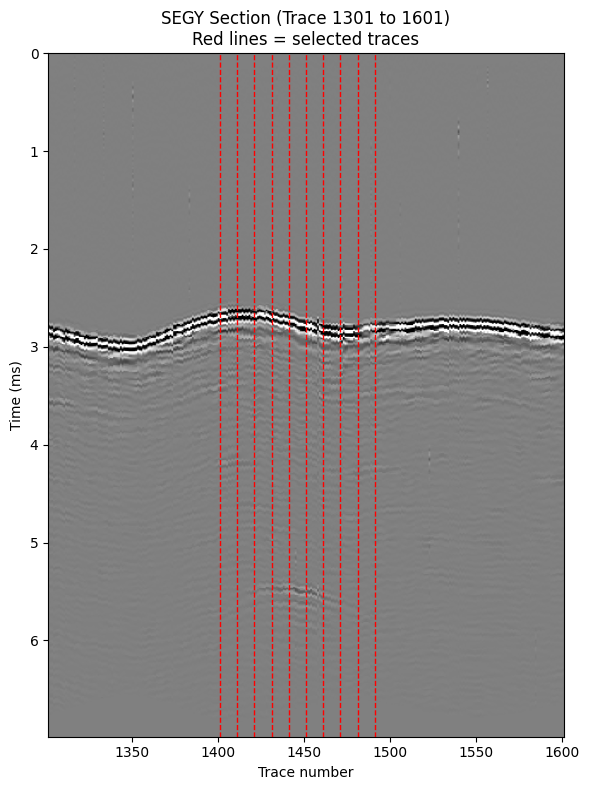

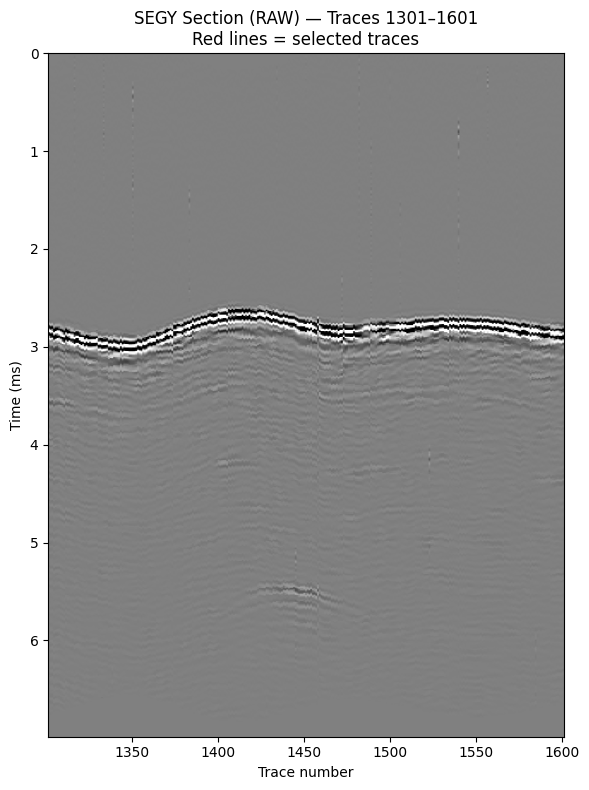

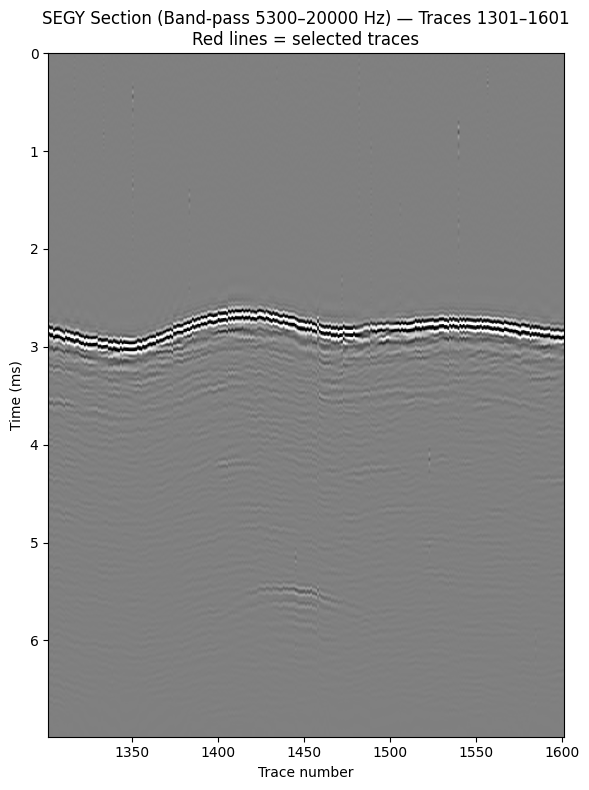

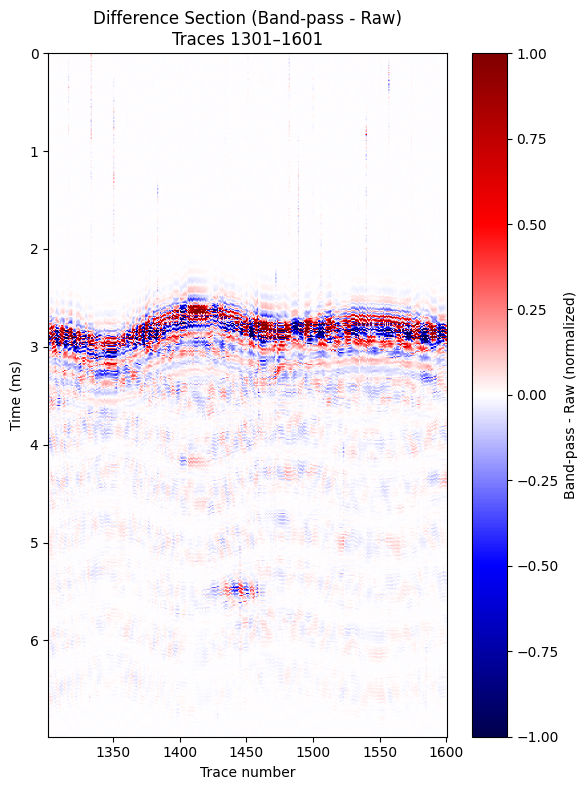

In [32]:
# pip install obspy numpy scipy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch
from obspy.io.segy.segy import _read_segy

# ====== 读取 SEG-Y ======
SEGY_PATH = "MMT(2015)_sgy/X-12_20150928_133437_RAW_LF.sgy"  # ← 改成你的文件
sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)

def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0: return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0: return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in header; using fallback {fallback_ms} ms.")
    return fallback_ms

dt_ms = get_dt_ms(sf)
fs = 1000.0 / dt_ms
print(f"Trace count: {n_traces}, fs = {fs:.1f} Hz, Nyquist = {fs/2:.1f} Hz")

# ====== 带通滤波器 ======
f_low, f_high = 5300.0, 20000.0
nyq = fs / 2.0
f1 = max(1.0, min(f_low,  nyq*0.95))
f2 = max(f1*1.05, min(f_high, nyq*0.95))
sos = butter(4, [f1/nyq, f2/nyq], btype="band", output="sos")

def bandpass_trace(x):
    return sosfiltfilt(sos, x.astype(np.float32), axis=0)

# ====== Wiggle trace indices ======
trace_start = 1400   # starting trace
step        = 10     # gap
n_waveforms = 10     # number of traces to draw
trace_indices = [trace_start + i*step for i in range(n_waveforms) if trace_start + i*step < n_traces]

# ====== Wiggle plot 函数 ======
def plot_wiggles(indices, filtered=False, amp_scale=2000, baseline_gap=2000, title_suffix=""):
    plt.figure(figsize=(25, 6))
    for k, idx in enumerate(indices):
        tr = sf.traces[idx].data.astype(np.float32)
        if filtered:
            tr = bandpass_trace(tr)
        t = np.arange(tr.size) * dt_ms
        p99 = np.percentile(np.abs(tr), 99)
        if p99 > 0: tr = tr / p99
        plt.plot(-tr * amp_scale + k*baseline_gap, t, color="black")

    plt.xticks(
        ticks=[k*baseline_gap for k in range(len(indices))],
        labels=[idx+1 for idx in indices]
    )
    plt.gca().invert_yaxis()
    plt.xlabel("Trace number (shifted baseline)")
    plt.ylabel("Time (ms)")
    plt.title(f"{len(indices)} traces, start {indices[0]+1}, every {step} {title_suffix}".strip())
    plt.tight_layout()
    plt.show()

# ====== 对比 Wiggle ======
plot_wiggles(trace_indices, filtered=True,
             amp_scale=2000, baseline_gap=2000,
             title_suffix=f"(band-pass {int(f1)}–{int(f2)} Hz)")
plot_wiggles(trace_indices, filtered=False,
             amp_scale=2000, baseline_gap=2000,
             title_suffix="(no filtering)")

# ====== 平均频谱（原始 vs 带通） ======
def average_spectrum(traces, fs, bandpass=False, step=5):
    amps = []
    for i in range(0, len(traces), step):
        tr = traces[i].data.astype(np.float32)
        if bandpass: tr = bandpass_trace(tr)
        tr = tr - np.mean(tr)
        N = len(tr)
        nperseg = min(2048, N)
        noverlap = max(0, nperseg//2 - 1)
        f, Pxx = welch(tr, fs=fs, nperseg=nperseg, noverlap=noverlap)
        amps.append(Pxx)
    A_avg = np.sqrt(np.mean(amps, axis=0))
    return f, A_avg

f_raw, A_raw = average_spectrum(sf.traces, fs, bandpass=False, step=5)
f_filt, A_filt = average_spectrum(sf.traces, fs, bandpass=True, step=5)

plt.figure(figsize=(8,5))
plt.plot(f_raw, A_raw, color="blue", label="No filtering (avg all traces)")
plt.plot(f_filt, A_filt, color="red", label=f"Band-pass {int(f1)}–{int(f2)} Hz (avg all traces)")
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Average spectrum comparison (all traces)")
plt.legend()
plt.tight_layout()
plt.show()

# ====== 2D 剖面图（选定范围） ======
start_trace = 1300
end_trace   = 1600
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

# 把数据读成 section
lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section = np.zeros((ns, n_show), dtype=np.float32)
for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section[:d.size, j] = d
times_ms = np.arange(ns) * dt_ms

# 简单归一化
p99 = np.percentile(np.abs(section), 99)
if p99 > 0: section = np.clip(section / p99, -1, 1)

plt.figure(figsize=(6, 8))
extent = [start_trace+1, end_trace+1, times_ms[-1], 0]
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
# 标记 wiggle 里选的 trace
for idx in trace_indices:
    if start_trace <= idx <= end_trace:
        plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Trace {start_trace+1} to {end_trace+1})\nRed lines = selected traces")
plt.tight_layout()
plt.show()
# ==== 构造 2D section（未滤波）====
start_trace = 1300
end_trace   = 1600
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section_raw = np.zeros((ns, n_show), dtype=np.float32)
for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section_raw[:d.size, j] = d
times_ms = np.arange(ns) * dt_ms

# ==== 构造 2D section（带通后）====
section_bp = np.zeros_like(section_raw)
for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section_bp[:d.size, j] = bandpass_trace(d)

# ==== 统一对比度（用两幅数据的联合 p99 做归一化）====
p99 = np.percentile(np.abs(np.concatenate([section_raw.ravel(), section_bp.ravel()])), 99)
if p99 > 0:
    section_raw_disp = np.clip(section_raw / p99, -1, 1)
    section_bp_disp  = np.clip(section_bp  / p99, -1, 1)
else:
    section_raw_disp = section_raw
    section_bp_disp  = section_bp

extent = [start_trace+1, end_trace+1, times_ms[-1], 0]

# ==== 图1：未滤波 2D 剖面 ====
plt.figure(figsize=(6, 8))
plt.imshow(section_raw_disp, aspect='auto', extent=extent, cmap="gray")
# for idx in trace_indices:
#     if start_trace <= idx <= end_trace:
#         plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (RAW) — Traces {start_trace+1}–{end_trace+1}\nRed lines = selected traces")
plt.tight_layout()
plt.show()

# ==== 图2：带通后 2D 剖面（5–20 kHz；或你的 f1–f2） ====
plt.figure(figsize=(6, 8))
plt.imshow(section_bp_disp, aspect='auto', extent=extent, cmap="gray")
# for idx in trace_indices:
#     if start_trace <= idx <= end_trace:
#         plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Band-pass {int(f1)}–{int(f2)} Hz) — Traces {start_trace+1}–{end_trace+1}\nRed lines = selected traces")
plt.tight_layout()
plt.show()
# ==== 差分剖面 ====
section_diff = section_bp - section_raw

# 归一化（用差分自己的 p99）
p99_diff = np.percentile(np.abs(section_diff), 99)
if p99_diff > 0:
    section_diff_disp = np.clip(section_diff / p99_diff, -1, 1)
else:
    section_diff_disp = section_diff

plt.figure(figsize=(6, 8))
extent = [start_trace+1, end_trace+1, times_ms[-1], 0]
plt.imshow(section_diff_disp, aspect='auto', extent=extent, cmap="seismic", vmin=-1, vmax=1)
# for idx in trace_indices:
#     if start_trace <= idx <= end_trace:
#         plt.axvline(idx+1, color='black', linestyle='--', linewidth=1)
plt.colorbar(label="Band-pass - Raw (normalized)")
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"Difference Section (Band-pass - Raw)\nTraces {start_trace+1}–{end_trace+1}")
plt.tight_layout()
plt.show()

## Apply Time Gain Control

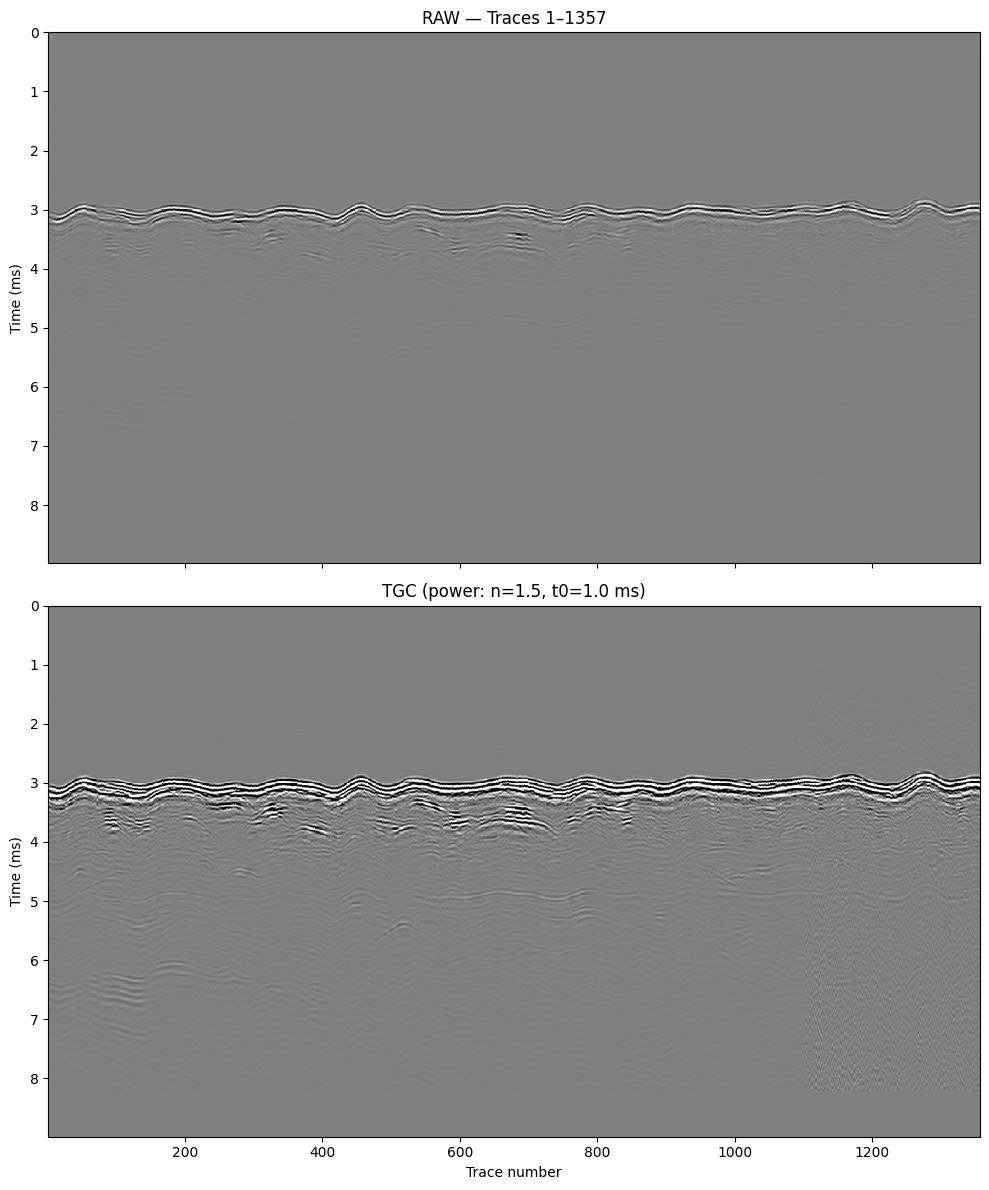

IndexError: list index out of range

In [1]:
# --- 如你已读取 sf/dt_ms，可把这一段注释掉 ---
from obspy.io.segy.segy import _read_segy
SEGY_PATH = "P3111_WOW2_08_20160915_100059_RAW_LF.sgy"
sf = _read_segy(SEGY_PATH, headonly=False)
# 采样间隔（毫秒）
try:
    dt_ms = sf.binary_file_header.sample_interval_in_microseconds / 1000.0
except Exception:
    dt_ms = sf.traces[0].stats.delta * 1000.0

import numpy as np
import matplotlib.pyplot as plt

# -------- TGC 核心函数 --------
def tgc_powerlaw(x, dt_ms, n=1.5, t0_ms=1.0):
    t = np.arange(x.size, dtype=np.float32) * (dt_ms)
    g = np.power(t + t0_ms, n, dtype=np.float32)
    return x.astype(np.float32) * g

def tgc_exponential(x, dt_ms, alpha=0.5):
    t = np.arange(x.size, dtype=np.float32) * (dt_ms)
    g = np.exp(alpha * t, dtype=np.float32)
    return x.astype(np.float32) * g

def apply_tgc_section(section, dt_ms, mode="power", **kwargs):
    out = np.empty_like(section, dtype=np.float32)
    for i in range(section.shape[1]):
        tr = section[:, i]
        if mode == "power":
            out[:, i] = tgc_powerlaw(tr, dt_ms, **kwargs)
        else:
            out[:, i] = tgc_exponential(tr, dt_ms, **kwargs)
    return out

# -------- 读区间成 2D 剖面（时间×道），自动补零对齐 --------
def load_section(sf, start_trace, end_trace):
    n_traces = len(sf.traces)
    idxs = range(start_trace, min(end_trace+1, n_traces))
    lengths = [sf.traces[i].data.size for i in idxs]
    ns = max(lengths)
    sec = np.zeros((ns, len(idxs)), dtype=np.float32)
    for j, i in enumerate(idxs):
        d = sf.traces[i].data.astype(np.float32)
        sec[:d.size, j] = d
    return sec, list(idxs)

# ========== 配置：选择区间 + TGC 参数 ==========
start_trace = 0
end_trace   = len(sf.traces) - 1

tgc_mode   = "power"     # "power" 或 "exp"
power_pars = dict(n=1.5, t0_ms=1.0)
exp_pars   = dict(alpha=0.005)

# ========== 加载区间 & 计算 TGC ==========
section_raw, trace_ids = load_section(sf, start_trace, end_trace)
section_tgc = apply_tgc_section(
    section_raw, dt_ms,
    mode=tgc_mode,
    **(power_pars if tgc_mode=="power" else exp_pars)
)

# 统一对比度显示（用合并后的 p99）
p99 = np.percentile(np.abs(np.concatenate([section_raw.ravel(), section_tgc.ravel()])), 99)
sec_raw_disp = section_raw if p99==0 else np.clip(section_raw/p99, -1, 1)
sec_tgc_disp = section_tgc if p99==0 else np.clip(section_tgc/p99, -1, 1)
times_ms = np.arange(section_raw.shape[0]) * dt_ms
extent = [trace_ids[0]+1, trace_ids[-1]+1, times_ms[-1], 0]

# ========== 图1：Raw vs TGC（2D 剖面对比）==========
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
axes[0].imshow(sec_raw_disp, aspect='auto', extent=extent, cmap="gray")
axes[0].set_title(f"RAW — Traces {trace_ids[0]+1}–{trace_ids[-1]+1}")
axes[0].set_ylabel("Time (ms)")
# axes[0].invert_yaxis()

axes[1].imshow(sec_tgc_disp, aspect='auto', extent=extent, cmap="gray")
if tgc_mode == "power":
    axes[1].set_title(f"TGC (power: n={power_pars['n']}, t0={power_pars['t0_ms']} ms)")
else:
    axes[1].set_title(f"TGC (exp: α={exp_pars['alpha']})")
axes[1].set_xlabel("Trace number")
axes[1].set_ylabel("Time (ms)")
# axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# ========== （可选）图2：单道对比，便于调参 ==========
# trace_idx = trace_ids[len(trace_ids)//2]  # 取中间一条看看
trace_idx = 1450
raw = sf.traces[trace_idx].data.astype(np.float32)
tgc = tgc_powerlaw(raw, dt_ms, **power_pars) if tgc_mode=="power" else tgc_exponential(raw, dt_ms, **exp_pars)
t = np.arange(raw.size) * dt_ms

plt.figure(figsize=(10,6))
plt.plot(raw, t, label=f"Raw (trace {trace_idx+1})", alpha=0.8)
plt.plot(tgc, t, label="After TGC", alpha=0.8)
plt.gca().invert_yaxis()
plt.xlabel("Amplitude")
plt.ylabel("Time (ms)")
plt.title("Single-trace comparison: Raw vs TGC")
plt.legend()
plt.tight_layout()
plt.show()

# ====== Wiggle style: 画给定范围内的 N 条道，每隔 step 取一条 ======
trace_start = 1400   # 起始 trace
step        = 8     # 每隔多少条取一条
n_waveforms = 10     # 总共画多少条
trace_indices = [trace_start + i*step for i in range(n_waveforms) if trace_start + i*step < len(sf.traces)]

plt.figure(figsize=(8, 6))
amp_scale = 2000   # 控制摆动幅度
baseline_gap = 2000  # 控制平移距离

for k, idx in enumerate(trace_indices):
    tr = sf.traces[idx].data.astype(np.float32)
    t  = np.arange(tr.size) * dt_ms

    # Normalize each trace individually to [-1, 1]（用99分位避免极值）
    p99 = np.percentile(np.abs(tr), 99)
    if p99 > 0:
        tr = tr / p99

    # wiggle 样式：加负号保证相位方向符合常见显示
    plt.plot(-tr * amp_scale + k*baseline_gap, t, color="black")

# 横坐标对齐到 trace 编号
plt.xticks(
    ticks=[k*baseline_gap for k in range(len(trace_indices))],
    labels=[idx+1 for idx in trace_indices]
)
plt.gca().invert_yaxis()
plt.xlabel("Trace number (shifted baseline)")
plt.ylabel("Time (ms)")
plt.title(f"{n_waveforms} traces, starting {trace_start+1}, every {step} traces\n(normalized wiggle style)")
plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt

# ====== Wiggle style: 画给定范围内的 N 条道（用 TGC 后的数据） ======
# trace_start = 1400   # 起始 trace
# step        = 7     # 每隔多少条取一条
# n_waveforms = 10     # 总共画多少条
# trace_indices = [trace_start + i*step for i in range(n_waveforms) if trace_start + i*step < len(sf.traces)]

plt.figure(figsize=(4, 6))
amp_scale = 2000      # 控制 wiggle 最大摆动
baseline_gap = 2000   # 控制左右平移距离

for k, idx in enumerate(trace_indices):
    if idx in trace_ids:                # 确保 idx 在当前 section 范围
        j = trace_ids.index(idx)        # 找到对应在 section_tgc 中的列
        tr = section_tgc[:, j]          # 从 TGC 后的 section 拿数据
        t  = np.arange(tr.size) * dt_ms

        # Normalize each trace individually to [-1, 1]
        p99 = np.percentile(np.abs(tr), 99)
        if p99 > 0:
            tr = tr / p99

        # wiggle 样式
        plt.plot(-tr * amp_scale + k*baseline_gap, t, color="black")

# 横坐标对齐 trace 编号
plt.xticks(
    ticks=[k*baseline_gap for k in range(len(trace_indices))],
    labels=[idx+1 for idx in trace_indices]
)
plt.gca().invert_yaxis()
plt.xlabel("Trace number (shifted baseline)")
plt.ylabel("Time (ms)")
plt.title(f"TGC Wiggle: {n_waveforms} traces, starting {trace_start+1}, every {step} traces")
plt.tight_layout()
plt.show()

def plot_traces(sf, dt_ms, start_trace1=1400, end_trace1=1500, step=10, n_show=10):
    """
    从 SEG-Y 文件对象 sf 中画 amplitude-time 曲线
    - start_trace: 起始 trace 编号（从 0 开始）
    - end_trace:   结束 trace 编号（包含）
    - step:        每隔多少条取一个 trace
    - n_show:      总共画多少条
    """
    # 生成 trace 索引
    trace_indices = [start_trace1 + i*step for i in range(n_show) if start_trace1 + i*step <= end_trace1]

    plt.figure(figsize=(12, 8))
    for idx in trace_indices:
        tr = sf.traces[idx].data.astype(np.float32)
        t = np.arange(tr.size) * dt_ms
        plt.plot(tr, t, label=f"Trace {idx+1}")
    
    plt.gca().invert_yaxis()
    plt.xlabel("Amplitude")
    plt.ylabel("Time (ms)")
    plt.title(f"Amplitude-Time of {len(trace_indices)} traces "
              f"(start {start_trace1+1}, step {step})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== 使用示例 ====
plot_traces(sf, dt_ms, start_trace1=1400, end_trace1=1500, step=10, n_show=10)
def plot_traces_tgc(section_tgc, trace_ids, dt_ms, start_trace1=1400, end_trace1=1500, step=10, n_show=10):
    """
    从 TGC 后的 section 里画 amplitude-time 曲线
    - section_tgc: apply_tgc_section 输出的 2D 数组 (ns × n_traces)
    - trace_ids:   load_section 返回的 trace 索引列表
    """
    # 找出在 trace_ids 范围内的索引
    trace_indices = [start_trace1 + i*step for i in range(n_show) if start_trace1 + i*step <= end_trace1]

    plt.figure(figsize=(12, 8))
    for idx in trace_indices:
        if idx in trace_ids:
            j = trace_ids.index(idx)   # 找到对应在 section_tgc 里的列号
            tr = section_tgc[:, j]
            t = np.arange(tr.size) * dt_ms
            plt.plot(tr, t, label=f"Trace {idx+1}")
    
    plt.gca().invert_yaxis()
    plt.xlabel("Amplitude")
    plt.ylabel("Time (ms)")
    plt.title(f"TGC Amplitude-Time of {len(trace_indices)} traces "
              f"(start {start_trace1+1}, step {step})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== 使用示例 ====
plot_traces_tgc(section_tgc, trace_ids, dt_ms,
                start_trace1=1400, end_trace1=1500, step=10, n_show=10)

In [53]:
# pip install segyio numpy
import segyio, numpy as np, shutil

src = "processed/18_bp_5k_20k.sgy"                 # 源文件（已 band-pass）
dst = "processed/18_bp_5k_20k_TGC_power_n1p5.sgy"  # 目标文件

# --- TGC 定义（和你前面一致） ---
def tgc_powerlaw(x, dt_ms, n=1.5, t0_ms=1.0):
    t = np.arange(x.size, dtype=np.float32) * dt_ms
    g = np.power(t + t0_ms, n, dtype=np.float32)
    return x.astype(np.float32) * g

def tgc_exponential(x, dt_ms, alpha=0.5):
    t = np.arange(x.size, dtype=np.float32) * dt_ms
    g = np.exp(alpha * t, dtype=np.float32)
    return x.astype(np.float32) * g

mode = "power"                          # "power" 或 "exp"
power_pars = dict(n=1.5, t0_ms=1.0)
exp_pars   = dict(alpha=0.5)

# 1) 先物理复制整个 SEG-Y 文件
shutil.copy2(src, dst)

# 2) 打开源文件读 dt；打开目标文件以写样点
with segyio.open(src, "r",  ignore_geometry=True) as fin, \
     segyio.open(dst, "r+", ignore_geometry=True) as fout:

    # 采样间隔：微秒 -> 毫秒
    dt_us = segyio.tools.dt(fin)
    dt_ms = float(dt_us) / 1000.0

    for i in range(fin.tracecount):
        tr = fin.trace[i].astype(np.float32)

        if mode == "power":
            tr_out = tgc_powerlaw(tr, dt_ms, **power_pars)
        else:
            tr_out = tgc_exponential(tr, dt_ms, **exp_pars)

        # 写回目标文件对应道
        fout.trace[i] = tr_out.astype(np.float32)

    # 可选：在文本头记录处理信息（若报错就略过）
    try:
        note = (f"TGC {mode} "
                f"{power_pars if mode=='power' else exp_pars} "
                f"(dt={dt_ms:.4f} ms)")
        fout.text[0] = segyio.tools.wrap(note)
    except Exception:
        pass

print("✅ 保存完成：", dst)

✅ 保存完成： processed/19_bp_5k_20k_TGC_power_n1p5.sgy


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, medfilt, savgol_filter

# ================ 工具函数 =================
def envelope(x):
    return np.abs(hilbert(x))

def seabed_pick(trace, t_ms, sigma=3.0, min_ms=0.0):
    """在包络上找第一个超过阈值的强峰（失败回退到全局最大）。"""
    env = envelope(trace.astype(np.float32))
    mask = t_ms >= min_ms
    env[~mask] = 0.0
    mu, sd = np.mean(env[mask]), np.std(env[mask]) + 1e-9
    thr = mu + sigma * sd
    idx = np.argmax(env > thr)
    if env[idx] > thr:
        return idx
    return np.argmax(env)

def collect_ridge_times(section, dt_ms, gate_ms=(1.0, 5.0), local_smooth="median", k=5):
    """
    对每条道：
      1) 拾取海床；
      2) 在床后 gate_ms=(start,len) 窗内，找包络峰值的时间；
      3) 对该窗内波形做一次小窗口平滑，提升鲁棒性。
    返回：ridge_times_ms (n_tr,)；单位 ms（无效为 nan）
    """
    ns, ntr = section.shape
    t_ms = np.arange(ns) * dt_ms
    g0, gl = gate_ms
    ridge = np.full(ntr, np.nan, dtype=np.float32)

    for j in range(ntr):
        tr = section[:, j]
        i_bed = seabed_pick(tr, t_ms, sigma=3.0, min_ms=0.0)
        i0 = int(i_bed + g0 / dt_ms)
        i1 = int(i0   + gl / dt_ms)
        i0 = max(0, i0); i1 = min(ns, i1)
        if i1 - i0 < 32:        # 窗太短就跳过
            continue
        win = tr[i0:i1].astype(np.float32)
        if local_smooth == "median":
            k2 = k if k % 2 else k+1
            win = medfilt(win, kernel_size=k2)
        elif local_smooth == "savgol":
            k2 = min(11, (len(win)//2)*2+1)
            win = savgol_filter(win, k2, polyorder=2, mode="interp")
        idx_local = i0 + np.argmax(envelope(win))
        ridge[j] = idx_local * dt_ms

    # 对 ridge 曲线再做一次全局平滑（只处理有效段）
    valid = ~np.isnan(ridge)
    if valid.sum() >= 7:
        x = np.flatnonzero(valid)
        y = ridge[valid]
        win = min(11, (len(y)//2)*2+1)  # 奇数窗
        ridge_smooth = ridge.copy()
        ridge_smooth[valid] = savgol_filter(y, window_length=win, polyorder=2, mode="interp")
        return ridge, ridge_smooth
    else:
        return ridge, ridge  # 数据太少，不再平滑

def quad_fit_robust(x, t, max_iter=4, sigma=2.0, w_center=1.0):
    """
    稳健二次拟合：t = A x^2 + B x + C
    - 迭代 σ-clipping 移除离群
    - 中心加权（靠近中位 x 的点权重大）
    返回 (a, x0, t0, R2, inlier_mask)
    """
    x = x.astype(float); t = t.astype(float)
    xc = np.median(x)
    w = 1.0 / (1.0 + ((x - xc)/(np.ptp(x)+1e-6))**2)   # 距中心近 → 权重大
    w = (1 - w_center) + w_center * w
    mask = np.ones_like(t, dtype=bool)

    for _ in range(max_iter):
        X = np.vstack([x[mask]**2, x[mask], np.ones(mask.sum())]).T
        W = np.diag(w[mask])
        beta, *_ = np.linalg.lstsq(W @ X, W @ t[mask], rcond=None)
        A, B, C = beta
        t_hat = X @ beta
        resid = t[mask] - t_hat
        s = np.std(resid) + 1e-9
        new_mask = np.zeros_like(mask)
        new_mask[mask] = np.abs(resid) < sigma*s
        if new_mask.sum() == mask.sum():
            mask = new_mask
            break
        mask = new_mask

    # 最终一次（用内点）
    X = np.vstack([x[mask]**2, x[mask], np.ones(mask.sum())]).T
    beta, *_ = np.linalg.lstsq(X, t[mask], rcond=None)
    A, B, C = beta
    # R² 用全部点评估（方便阈值统一）
    Xfull = np.vstack([x**2, x, np.ones_like(x)]).T
    t_hat_full = Xfull @ beta
    ss_res = np.sum((t - t_hat_full)**2)
    ss_tot = np.sum((t - np.mean(t))**2) + 1e-12
    R2 = 1 - ss_res/ss_tot
    if abs(A) < 1e-12:
        return None, None, None, 0.0, mask
    x0 = -B / (2*A)
    t0 = C - B**2 / (4*A)
    return A, x0, t0, R2, mask

# ================ 主检测函数 =================
def detect_hyperbola_quad(section, trace_ids, dt_ms,
                          gate_ms=(1.0, 5.0),
                          local_smooth="median", k=7,
                          deriv_smooth_win= 9,    # dt/dx 的平滑窗（奇数）
                          fit_half_width=12,
                          min_points=12,
                          R2_thresh=0.90, a_min=1e-6,
                          plot=True):
    """
    使用“dt/dx 换号 + 稳健二次拟合”检测 hyperbola。
    返回 dict：{
      detected, reason, apex_trace, apex_time_ms,
      a, x0, t0, R2, ridge_raw, ridge_smooth
    }
    """
    ns, ntr = section.shape
    t_ms = np.arange(ns) * dt_ms

    # 1) 床后 ridge（原始 & 平滑）
    ridge, ridge_s = collect_ridge_times(section, dt_ms, gate_ms, local_smooth, k)
    valid = ~np.isnan(ridge_s)
    if valid.sum() < min_points:
        return {"detected": False, "reason": "not enough ridge points", "ridge_raw": ridge, "ridge_smooth": ridge_s}

    x = np.array(trace_ids)[valid].astype(float)
    y = ridge_s[valid].astype(float)

    # 2) 计算 dt/dx 并找“负→正”的换号点（apex）
    win = min(deriv_smooth_win if deriv_smooth_win % 2 else deriv_smooth_win+1, (len(y)//2)*2+1)
    y_for_grad = savgol_filter(y, window_length=win, polyorder=2, mode="interp")
    dy_dx = np.gradient(y_for_grad, x)

    i_min = np.argmin(y_for_grad)  # 先找时间最小的附近
    sign = np.sign(dy_dx)
    zc = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0]   # 负→正
    if zc.size == 0:
        if plot:
            print("[Info] No slope sign-change (neg→pos).")
        return {"detected": False, "reason": "no negative-to-positive slope change",
                "ridge_raw": ridge, "ridge_smooth": ridge_s}

    i0 = zc[np.argmin(np.abs(zc - i_min))]     # 离最小点最近的换号
    apex_x = 0.5 * (x[i0] + x[i0+1])
    apex_t = 0.5 * (y_for_grad[i0] + y_for_grad[i0+1])

    # 3) 以 apex 为中心的拟合窗口
    left  = max(0, i0 - fit_half_width)
    right = min(len(x), i0 + 1 + fit_half_width)
    x_fit = x[left:right]
    t_fit = y[left:right]
    if x_fit.size < min_points:
        return {"detected": False, "reason": "not enough points around apex",
                "ridge_raw": ridge, "ridge_smooth": ridge_s}

    # 4) 稳健二次拟合
    a, x0, t0, R2, inliers = quad_fit_robust(x_fit, t_fit, max_iter=4, sigma=2.0, w_center=1.0)
    if a is None or a <= a_min or R2 < R2_thresh:
        if plot:
            print(f"[Info] poor quad fit: a={a}, R2={R2:.2f}")
        return {"detected": False, "reason": f"poor quad fit (a={a}, R2={R2:.2f})",
                "ridge_raw": ridge, "ridge_smooth": ridge_s}

    result = {
        "detected": True,
        "apex_trace": float(apex_x),
        "apex_time_ms": float(apex_t),
        "a": float(a), "x0": float(x0), "t0": float(t0), "R2": float(R2),
        "ridge_raw": ridge, "ridge_smooth": ridge_s,
        "fit_window_idx": (left, right)
    }

    # 5) 可视化
    if plot:
        # (A) ridge & dt/dx
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(np.array(trace_ids)[~np.isnan(ridge)], ridge[~np.isnan(ridge)], 'k.', ms=3, alpha=0.6, label="ridge raw")
        ax[0].plot(x, y, 'C0-', lw=2, label="ridge smooth")
        ax[0].axvline(apex_x, color='r', ls='--', label="apex")
        ax[0].invert_yaxis(); ax[0].set_xlabel("Trace number"); ax[0].set_ylabel("Time (ms)")
        ax[0].legend(); ax[0].set_title("Ridge & apex")

        ax[1].plot(x, dy_dx, 'C1-'); ax[1].axhline(0, color='k', lw=1)
        ax[1].axvline(apex_x, color='r', ls='--')
        ax[1].set_xlabel("Trace number"); ax[1].set_ylabel("dt/dx (ms/trace)")
        ax[1].set_title("Slope (dt/dx)")
        plt.tight_layout(); plt.show()

        # (B) 在剖面上叠加拟合曲线
        ns, ntr = section.shape
        times_ms = np.arange(ns) * dt_ms
        extent = [trace_ids[0]+1, trace_ids[-1]+1, times_ms[-1], times_ms[0]]
        p99 = np.percentile(np.abs(section), 99)
        disp = section if p99==0 else np.clip(section/p99, -1, 1)

        xx = np.linspace(trace_ids[0]+1, trace_ids[-1]+1, 400)
        yy = a*(xx - x0)**2 + t0

        plt.figure(figsize=(10, 6))
        plt.imshow(disp, aspect='auto', extent=extent, cmap='gray')
        plt.plot(xx, yy, 'c--', lw=2, label=f"quad fit  R²={R2:.2f}")
        plt.scatter([apex_x], [apex_t], c='r', s=30, label='apex')
        plt.gca().invert_yaxis(); plt.xlabel("Trace number"); plt.ylabel("Time (ms)")
        plt.title("Hyperbola fit on section")
        plt.legend(); plt.tight_layout(); plt.show()

    return result

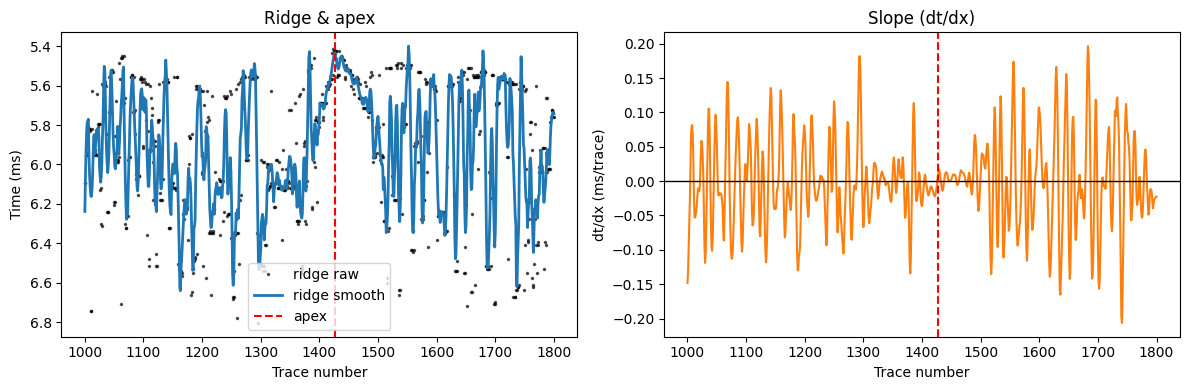

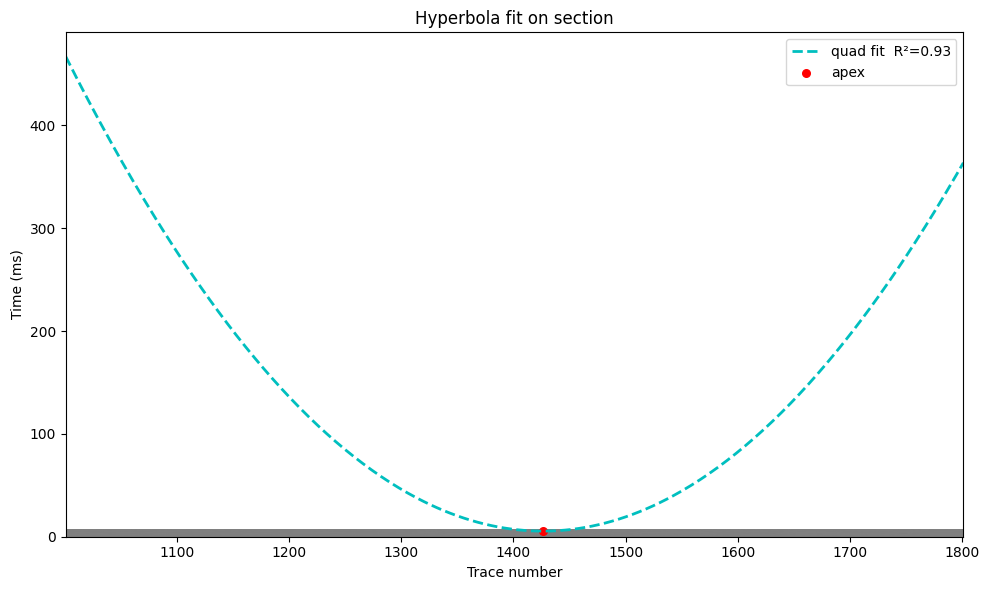

{'detected': True, 'apex_trace': 1426.5, 'apex_time_ms': 5.444128572801901, 'a': 0.0025522473093560895, 'x0': 1426.3483635922703, 't0': 5.445918880696809, 'R2': 0.9291194298179971, 'ridge_raw': array([6.096, 6.096, 5.952, 5.952, 5.94 , 5.808, 5.808, 5.82 , 5.82 ,
       5.832, 6.744, 6.744, 5.628, 5.82 , 5.94 , 5.952, 5.94 , 5.94 ,
       5.928, 5.952, 5.64 , 5.952, 5.808, 5.796, 5.796, 6.132, 5.796,
       6.12 , 6.3  , 6.312, 5.592, 5.604, 5.592, 5.604, 5.58 , 5.592,
       5.604, 5.844, 6.24 , 6.24 , 6.24 , 5.556, 5.736, 5.736, 5.52 ,
       5.736, 5.52 , 5.532, 5.532, 6.204, 6.192, 6.192, 5.856, 5.676,
       5.976, 5.988, 5.988, 5.976, 5.964, 5.484, 5.568, 6.708, 5.46 ,
       5.448, 5.46 , 5.688, 5.448, 5.688, 5.664, 6.3  , 6.324, 6.324,
       6.264, 6.264, 5.976, 5.964, 5.964, 5.964, 5.556, 5.556, 5.544,
       5.544, 5.736, 5.556, 5.736, 5.724, 5.844, 6.048, 6.072, 6.072,
       6.048, 6.156, 6.06 , 6.06 , 5.568, 5.556, 5.568, 5.568, 5.58 ,
       5.916, 5.904, 5.568, 5.712, 5

In [151]:
res = detect_hyperbola_quad(
    section_tgc, trace_ids, dt_ms,
    gate_ms=(2.8, 6.0),        # 床后 1–5 ms 窗口（按你数据调）
    local_smooth="savgol", k=11,
    deriv_smooth_win=11,        # 计算 dt/dx 前的平滑
    fit_half_width=6,         # apex 左右各取 12 个点拟合
    min_points=12,
    R2_thresh=0.603, a_min=1e-6,
    plot=True
)
print(res)


[INFO] dt = 0.0120 ms
[INFO] section shape = (samples=583, traces=1701)
[INFO] Found 15 candidate(s) with R² >= 0.5


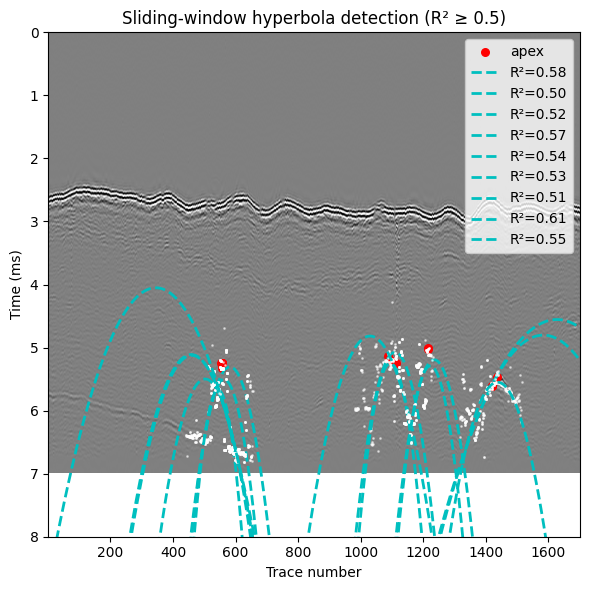

In [63]:
# -*- coding: utf-8 -*-
# pip install obspy numpy matplotlib scipy
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy
from scipy.signal import hilbert, savgol_filter, medfilt

# ===================== 参数区（改这里） =====================
SEGY_PATH       = "processed/output_bp_5k_20k_TGC_power_n1p5.sgy"   # ← 换成你的SEG-Y/SGY文件
START_TRACE     = 0              # 扫描起始道号（0基）
END_TRACE       = 1700              # 扫描结束道号（含，0基）

# 滑动窗口参数（以道数为单位）
GATE_MS        = (2, 5.0)   # 更贴近海床，避免深部噪声
LOCAL_SMOOTH   = "savgol"; K_LOCAL = 13
DERIV_SMOOTH   = 17
FIT_HALF_WIDTH = 60
MIN_POINTS     = 41
R2_THRESH      = 0.5
A_MIN          = 5e-9
# 滑窗
WIN_TRACES     = 120
STRIDE         = 5
# 支持度：band_ms=0.5, hit_frac>=0.55, min_consecutive>=10
# ===========================================================


# ===================== 工具函数 =====================
def load_section(sf, start_trace, end_trace):
    """把指定 trace 区间读成 2D 剖面（时间 × 道），自动补零对齐。"""
    n_total = len(sf.traces)
    start_trace = max(0, start_trace)
    end_trace   = min(end_trace, n_total - 1)
    idxs = list(range(start_trace, end_trace + 1))
    lengths = [sf.traces[i].data.size for i in idxs]
    ns = max(lengths)
    sec = np.zeros((ns, len(idxs)), dtype=np.float32)
    for j, i in enumerate(idxs):
        d = sf.traces[i].data.astype(np.float32)
        sec[:d.size, j] = d
    return sec, idxs

def envelope(x):
    """解析包络"""
    return np.abs(hilbert(x.astype(np.float32)))

def seabed_pick(trace, t_ms, sigma=3.0, min_ms=0.0):
    """在包络上寻找第一个超阈值峰作为海床；失败回退全局最大。"""
    env = envelope(trace)
    mask = t_ms >= min_ms
    env[~mask] = 0.0
    mu, sd = np.mean(env[mask]), np.std(env[mask]) + 1e-9
    thr = mu + sigma * sd
    idx = np.argmax(env > thr)
    if env[idx] > thr:
        return int(idx)
    return int(np.argmax(env))

# def pick_ridge_below_seabed(section, trace_ids, dt_ms,
#                             gate_ms=(2.8, 6.0),
#                             local_smooth="savgol", k=11):
#     """
#     对每条道：
#       1) seabed拾取
#       2) 在海床后 gate_ms 窗内：平滑(win) → 包络主峰 → ridge时间
#     返回：x_all(道号), y_all(ms)；可能含 NaN（拾取失败）
#     """
#     ns, ntr = section.shape
#     t_ms = np.arange(ns) * dt_ms
#     g0, gl = gate_ms

#     ridge_t = np.full(ntr, np.nan, dtype=np.float32)

#     for j in range(ntr):
#         tr = section[:, j]
#         i_bed = seabed_pick(tr, t_ms, sigma=3.0, min_ms=0.0)

#         i0 = int(i_bed + g0 / dt_ms)    # 窗起
#         i1 = int(i0   + gl / dt_ms)     # 窗终
#         i0 = max(0, i0); i1 = min(ns, i1)
#         if i1 - i0 < 32:      # 太短不可靠
#             continue

#         win = tr[i0:i1].astype(np.float32)
#         # 局部平滑
#         if local_smooth == "median":
#             k2 = k if k % 2 else k + 1
#             win = medfilt(win, kernel_size=k2)
#         elif local_smooth == "savgol":
#             # savgol窗长需奇数且不超过窗口长度
#             k2 = min(k if k % 2 else k+1, (len(win)//2)*2+1)
#             k2 = max(5, k2)
#             win = savgol_filter(win, k2, polyorder=2, mode="interp")

#         ridx = int(i0 + np.argmax(envelope(win)))
#         ridge_t[j] = ridx * dt_ms

#     x_all = np.array(trace_ids, dtype=float)
#     y_all = ridge_t.astype(float)
#     return x_all, y_all
from scipy.signal import find_peaks

def pick_ridge_below_seabed(section, trace_ids, dt_ms,
                            gate_ms=(2.8, 6.0),
                            local_smooth="savgol", k=11,
                            prominence=0.15,      # 峰值显著性阈值（相对归一化后）
                            d_ms_max=1.5,        # 允许相邻两道的时间跳动（ms）
                            topN=3,               # 每道最多考虑的候选峰个数
                            median_smooth=5,      # 最后对轨迹做中值平滑（奇数）
                            sub_sample=True):     # 是否做亚采样抛物线插值
    """
    连续性约束的 ridge 跟踪（海床之后）：
      - gate 内平滑+包络
      - find_peaks(prominence) 提出若干候选
      - 逐道跟踪，优先选距前一道时间差 <= d_ms_max 的最佳候选
      - 结果中值平滑；可选亚采样插值
    返回：x_all(道号), y_all(ms)
    """
    ns, ntr = section.shape
    t_ms = np.arange(ns, dtype=np.float32) * dt_ms
    g0, gl = gate_ms

    # 预先做每道的候选池
    cand_times = []   # list of arrays (ms)
    cand_scores = []  # 同步存储峰值“强度”（包络幅度）

    # 为了让 prominence 有意义，先对 gate 窗内幅度做 robust 归一
    def _norm(x):
        p99 = np.percentile(np.abs(x), 99) + 1e-9
        return x / p99

    for j in range(ntr):
        tr = section[:, j].astype(np.float32)

        # seabed
        i_bed = seabed_pick(tr, t_ms, sigma=3.0, min_ms=0.0)
        i0 = int(i_bed + g0 / dt_ms)
        i1 = int(i0   + gl / dt_ms)
        i0 = max(0, i0); i1 = min(ns, i1)
        if i1 - i0 < 32:
            cand_times.append(np.array([], dtype=np.float32))
            cand_scores.append(np.array([], dtype=np.float32))
            continue

        win = tr[i0:i1].copy()

        # 局部平滑
        if local_smooth == "median":
            kk = k if k % 2 else k+1
            win = medfilt(win, kk)
        else:
            kk = min(k if k % 2 else k+1, (len(win)//2)*2+1)
            kk = max(5, kk)
            win = savgol_filter(win, kk, polyorder=2, mode="interp")

        env = np.abs(hilbert(win))
        env_n = _norm(env)

        # 取若干显著峰
        pk, props = find_peaks(env_n, prominence=prominence)
        if pk.size > 0:
            # 选最强 topN
            order = np.argsort(props["prominences"])[::-1][:topN]
            pk = pk[order]
            sc = env[pk]  # 用未归一化的包络幅度作为“强度”
            tpk = t_ms[i0 + pk]
        else:
            tpk = np.array([], dtype=np.float32)
            sc  = np.array([], dtype=np.float32)

        cand_times.append(tpk)
        cand_scores.append(sc)

    # 逐道跟踪
    ridge_t = np.full(ntr, np.nan, dtype=np.float32)
    prev_t = None
    for j in range(ntr):
        tpk = cand_times[j]
        sc  = cand_scores[j]
        if tpk.size == 0:
            prev_t = None
            continue

        if prev_t is None:
            # 没有历史，就选最“浅”的一个（时间最小）或最强的一个
            # 这里选最浅，贴近 hyperbola 顶部
            idx = np.argmax(sc)
        else:
            # 在允许跳动范围内找候选；没有就退化为最浅
            mask = np.abs(tpk - prev_t) <= d_ms_max
            if np.any(mask):
                idx = np.argmax(sc[mask])  # 允许范围内选最强
                idx = np.flatnonzero(mask)[idx]
            else:
                idx = np.argmin(tpk)

        ridge_t[j] = tpk[idx]
        prev_t = ridge_t[j]

    # 去 NaN（简单插值）+ 轨迹中值平滑
    valid = np.isfinite(ridge_t)
    if valid.sum() >= 3:
        # 线性插值填 NaN
        xv = np.flatnonzero(valid)
        tv = ridge_t[valid]
        xi = np.arange(ntr)
        ridge_t = np.interp(xi, xv, tv)

    if median_smooth and median_smooth >= 3:
        mm = median_smooth if median_smooth % 2 else median_smooth+1
        ridge_t = medfilt(ridge_t, mm)

    # 亚采样抛物线插值（把每个峰顶再精修 0.1–0.2 个采样点量级）
    if sub_sample:
        for j in range(ntr):
            tr = section[:, j].astype(np.float32)
            i = int(round(ridge_t[j] / dt_ms))
            i = max(1, min(ns-2, i))
            # 在 i-1,i,i+1 上抛物线拟合，更新子采样峰值位置
            y0, y1, y2 = tr[i-1], tr[i], tr[i+1]
            denom = (y0 - 2*y1 + y2)
            if abs(denom) > 1e-9:
                delta = 0.5*(y0 - y2)/denom   # 峰值偏移（单位：样点）
                ridge_t[j] = (i + delta) * dt_ms

    x_all = np.asarray(trace_ids, dtype=float)
    y_all = ridge_t.astype(float)
    return x_all, y_all

def detect_one_apex_quadratic(x_all, y_all,
                              deriv_smooth_win=11,
                              fit_half_width=6,
                              min_points=12,
                              R2_thresh=0.9, a_min=1e-6,
                              a_sign="positive",           # 只保留视觉“口朝下”(数学 a>0)
                              use_support=True,            # 是否做支持度二次筛
                              band_ms=0.4, hit_frac_min=0.55, min_run=10):
    """
    - ridge (x_all, y_all) 轻平滑 → dt/dx
    - 先找 dt/dx 的负→正零交叉作为 apex；若没有，回退到平滑 ridge 的全局最小点
    - 以 apex 为中心在横向取小窗拟合 y = a(x-x̄)^2 + b(x-x̄) + c
    - 过滤：R²、|a|、a 符号(可选)；以及支持度(可选)
    返回 (ok, result_dict/None)
    """
    # 1) 清理
    valid = np.isfinite(x_all) & np.isfinite(y_all)
    x_all = x_all[valid]; y_all = y_all[valid]
    if x_all.size < min_points:
        return False, None

    # 2) 平滑 ridge（用于导数 & apex 判定）
    win = deriv_smooth_win if deriv_smooth_win % 2 else deriv_smooth_win + 1
    win = min(win, (len(y_all)//2)*2+1)
    win = max(5, win)
    y_s = savgol_filter(y_all, window_length=win, polyorder=2, mode="interp")

    # 3) 求导找零交叉（负→正）；兜底：全局最小点
    dy_dx = np.gradient(y_s, x_all)
    sign  = np.sign(dy_dx)
    zc    = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0]
    i_min = int(np.argmin(y_s))
    if zc.size:
        i0 = zc[np.argmin(np.abs(zc - i_min))]
        apex_x = 0.5 * (x_all[i0] + x_all[i0+1])
        apex_y = 0.5 * (y_s[i0]   + y_s[i0+1])
    else:
        i0 = i_min
        apex_x = x_all[i0]
        apex_y = y_s[i0]

    # 4) 以 apex 为中心取小窗做二次拟合
    left  = max(0, i0 - fit_half_width)
    right = min(len(x_all), i0 + 1 + fit_half_width)
    x = x_all[left:right]
    y = y_all[left:right]
    if len(x) < min_points:
        return False, None

    x0 = np.mean(x)
    coeffs = np.polyfit(x - x0, y, 2)         # a, b, c
    a, b, c = coeffs
    y_fit = np.polyval(coeffs, x - x0)

    # 5) 质量指标
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    R2 = 1 - ss_res/ss_tot if ss_tot > 0 else 0.0

    # 6) 基本阈值：R²、|a|、a 符号（视觉口朝下 ⇔ a>0）
    ok = (R2 >= R2_thresh) and (abs(a) >= a_min)
    if a_sign == "positive":
        ok = ok and (a > 0)
    elif a_sign == "negative":
        ok = ok and (a < 0)
    if not ok:
        return False, None

    # 7) 可选：支持度（二次筛，抗噪更稳）
    if use_support:
        resid = np.abs(y - y_fit)
        hit = resid <= band_ms
        hit_frac = hit.mean()
        # 最长连续命中
        run = max_run = 0
        for h in hit:
            run = run + 1 if h else 0
            max_run = max(max_run, run)
        if not (hit_frac >= hit_frac_min and max_run >= min_run):
            return False, None

    return True, dict(
            a=float(a), b=float(b), c=float(c), R2=float(R2),
            x=x, y=y, y_fit=y_fit,
            ridge_all=(x_all, y_all),
            apex=(float(apex_x), float(apex_y))
    )

def multi_detect_windowed(section, trace_ids, dt_ms,
                          gate_ms=(2.8, 6.0),
                          local_smooth="savgol", k=11,
                          deriv_smooth_win=11,
                          fit_half_width=6,
                          min_points=12,
                          R2_thresh=0.9, a_min=1e-6,
                          win_traces=120, stride=30):
    """
    滑动窗口扫描：
      - 每个子窗口内：海床拾取 → 床后窗口 ridge → apex 小窗二次拟合
      - 收集所有 R²≥阈值 的候选
    返回：list[ result_dict ]
    """
    results = []
    ntr = section.shape[1]

    for s in range(0, max(1, ntr - win_traces + 1), stride):
        sub = section[:, s:s+win_traces]
        sub_ids = trace_ids[s:s+win_traces]

        # 1) ridge
        x_all, y_all = pick_ridge_below_seabed(
            sub, sub_ids, dt_ms,
            gate_ms=gate_ms,
            local_smooth=local_smooth, k=k
        )

        # 2) apex + 小窗拟合
        ok, res = detect_one_apex_quadratic(
            x_all, y_all,
            deriv_smooth_win=deriv_smooth_win,
            fit_half_width=fit_half_width,
            min_points=min_points,
            R2_thresh=R2_thresh, a_min=a_min
        )
        if ok:
            results.append(res)

    return results

def show_section_with_results(section, trace_ids, dt_ms, res_list, title=""):
    """二维剖面 + 叠加所有候选的 ridge 点与拟合曲线"""
    # 归一显示提升对比度
    p99 = np.percentile(np.abs(section), 99)
    disp = section if p99 == 0 else np.clip(section / p99, -1, 1)

    times_ms = np.arange(section.shape[0]) * dt_ms
    extent = [trace_ids[0]+1, trace_ids[-1]+1, times_ms[-1], 0]  # 上0ms，下更大

    plt.figure(figsize=(6, 6))
    plt.imshow(disp, aspect='auto', extent=extent, cmap='gray')

    for res in res_list:
        # ridge（可选：只画子集）
        xa, ya = res["ridge_all"]
        plt.plot(xa+1, ya, "w.", ms=2, alpha=0.5)

        # apex
        ax, ay = res["apex"]
        plt.scatter([ax+1], [ay], c='r', s=30, label="apex")

        # 二次拟合曲线（用横轴均匀采样画）
        x_line = np.linspace(trace_ids[0], trace_ids[-1], 400)
        # 用该候选点的局部中心（与拟合一致）来计算
        x_sub_mean = np.mean(res["x"])
        y_line = np.polyval([res["a"], res["b"], res["c"]], x_line - x_sub_mean)
        plt.plot(x_line+1, y_line, "c--", lw=2, label=f"R²={res['R2']:.2f}")

    plt.xlabel("Trace number")
    plt.ylabel("Time (ms)")
    plt.title(title if title else "Detected hyperbolas")
    plt.ylim(8, 0)
    # 避免重复图例项过多
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        plt.legend(by_label.values(), by_label.keys(), loc="upper right")
    plt.tight_layout()
    plt.show()


# ===================== 主流程 =====================
if __name__ == "__main__":
    # 读取SEG-Y
    sf = _read_segy(SEGY_PATH, headonly=False)
    try:
        dt_ms = sf.binary_file_header.sample_interval_in_microseconds / 1000.0
    except Exception:
        dt_ms = sf.traces[0].stats.delta * 1000.0
    print(f"[INFO] dt = {dt_ms:.4f} ms")

    # 读区间
    section, trace_ids = load_section(sf, START_TRACE, END_TRACE)
    print(f"[INFO] section shape = (samples={section.shape[0]}, traces={section.shape[1]})")

    # 滑动窗口检测
    res_list = multi_detect_windowed(
        section, trace_ids, dt_ms,
        gate_ms=GATE_MS,
        local_smooth=LOCAL_SMOOTH, k=K_LOCAL,
        deriv_smooth_win=DERIV_SMOOTH,
        fit_half_width=FIT_HALF_WIDTH,
        min_points=MIN_POINTS,
        R2_thresh=R2_THRESH, a_min=A_MIN,
        win_traces=WIN_TRACES, stride=STRIDE
    )
    print(f"[INFO] Found {len(res_list)} candidate(s) with R² >= {R2_THRESH}")

    # 可视化
    show_section_with_results(
        section, trace_ids, dt_ms, res_list,
        title=f"Sliding-window hyperbola detection (R² ≥ {R2_THRESH})"
        )

[INFO] top-2 candidates:
  x0=1317, tau0=1.00 ms, c=0.10, score=47.1
  x0=1545, tau0=1.00 ms, c=0.10, score=44.5


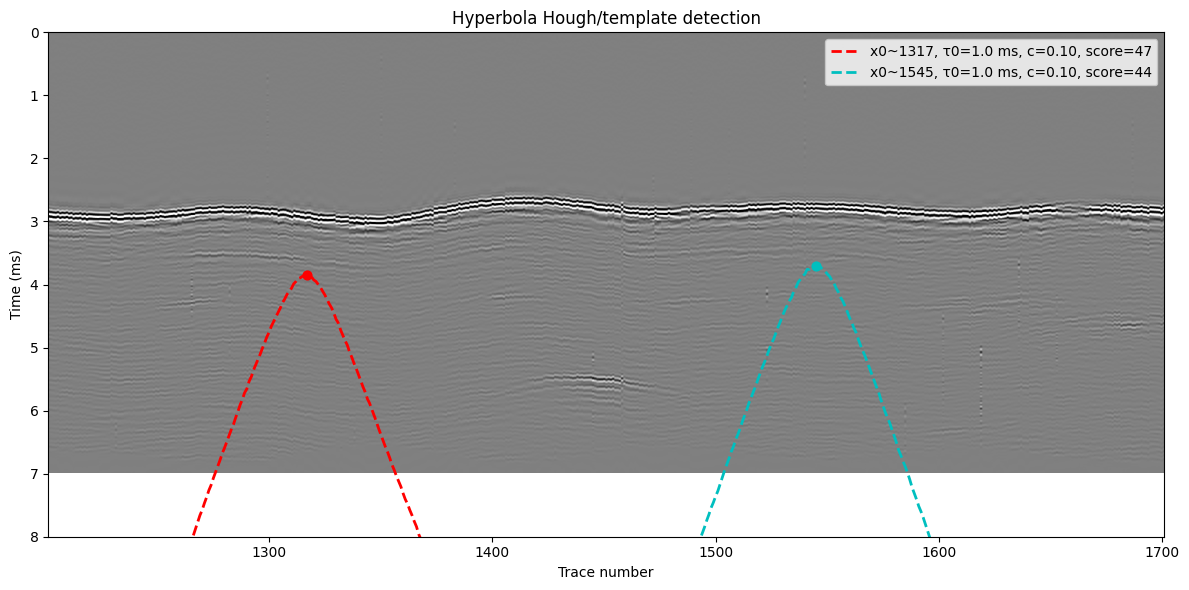

In [23]:
# -*- coding: utf-8 -*-
# pip install obspy numpy matplotlib scipy
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy
from scipy.signal import hilbert, savgol_filter, medfilt

# ===================== 参数区（改这里） =====================
SEGY_PATH       = "processed/output_bp_5k_20k_TGC_power_n1p5.sgy"
START_TRACE     = 1200
END_TRACE       = 1700

# 海床后对齐与搜索窗（相对海床的毫秒）
BED_GATE_MS     = (1.0, 9.0)     # 电缆一般不在海床正下0-0.5ms，给 1–15ms 比较稳
LOCAL_SMOOTH    = ("savgol", 11)  # (方式, 窗长)；可选 ("median", 7)

# Hough/模板搜索参数
X_STRIDE        = 2               # x0 的步长（trace）
X_HALF_WIN      = 100              # 曲线评分时两侧横向覆盖道数
TAU0_RANGE      = (1.0, 12.0, 0.1)  # τ0 ∈ [min,max,step] ms（相对海床的顶点时间）
C_RANGE         = (0.1, 3.5, 0.05)  # 曲率参数 c（ms/trace）：大→更陡
BAND_T_SAMPLES  = 1               # 允许沿曲线取 ±1 个样点内的最大值（抗离散）
TOPK            = 3               # 返回前 K 个候选

# 显示控制
PLOT_TIME_LIM_MS = (0, 8)         # 图像纵轴（绝对时间，ms）；根据你的数据改
# ===========================================================


def load_section(sf, start_trace, end_trace):
    n_total = len(sf.traces)
    start_trace = max(0, start_trace)
    end_trace   = min(end_trace, n_total - 1)
    idxs = list(range(start_trace, end_trace + 1))
    lengths = [sf.traces[i].data.size for i in idxs]
    ns = max(lengths)
    sec = np.zeros((ns, len(idxs)), dtype=np.float32)
    for j, i in enumerate(idxs):
        d = sf.traces[i].data.astype(np.float32)
        sec[:d.size, j] = d
    return sec, np.array(idxs)

def envelope(x): return np.abs(hilbert(x.astype(np.float32)))

def seabed_pick(trace, t_ms, sigma=3.0, min_ms=0.0):
    env = envelope(trace)
    mask = t_ms >= min_ms
    env[~mask] = 0.0
    mu, sd = np.mean(env[mask]), np.std(env[mask]) + 1e-9
    thr = mu + sigma * sd
    idx = np.argmax(env > thr)
    if env[idx] > thr:
        return int(idx)
    return int(np.argmax(env))

def build_aligned_envelope(section, dt_ms, gate_ms, local_smooth=("savgol",11)):
    ns, ntr = section.shape
    t_ms = np.arange(ns, dtype=np.float32)*dt_ms

    # 海床逐道拾取
    bed_idx = np.zeros(ntr, dtype=np.int32)
    for j in range(ntr):
        bed_idx[j] = seabed_pick(section[:, j], t_ms, sigma=3.0, min_ms=0.0)

    g0, g1 = gate_ms
    n_tau  = int(np.floor((g1 - g0) / dt_ms)) + 1
    tau_axis = (g0 + np.arange(n_tau)*dt_ms).astype(np.float32)

    env_aligned = np.zeros((n_tau, ntr), dtype=np.float32)
    for j in range(ntr):
        i0 = int(bed_idx[j] + g0/dt_ms)
        i1 = i0 + n_tau
        i0c, i1c = max(0,i0), min(ns,i1)
        win = section[i0c:i1c, j].astype(np.float32)

        # 局部平滑
        mode, k = local_smooth
        if mode == "median":
            k2 = k if k%2 else k+1
            win = medfilt(win, k2)
        else:
            k2 = min(k if k%2 else k+1, (len(win)//2)*2+1)
            k2 = max(5, k2)
            from scipy.signal import savgol_filter
            win = savgol_filter(win, k2, polyorder=2, mode="interp")

        env = envelope(win)

        # 归一化（鲁棒 p99）
        p99 = np.percentile(env, 99) + 1e-9
        env = env / p99

        # 放回对齐矩阵
        dst0 = max(0, -min(0, i0))      # 目标起点校正
        src0 = max(0,  i0 - i0c)        # 源起点校正（通常为0）
        ncpy = min(n_tau - dst0, env.size - src0)
        if ncpy > 0:
            env_aligned[dst0:dst0+ncpy, j] = env[src0:src0+ncpy]

    return env_aligned, tau_axis, bed_idx

def score_one_curve(env_aligned, dt_ms, tau_axis, x0, tau0, c, x_half_win, band=1):
    """
    在对齐后的包络图上，沿 τ(x) = sqrt(tau0^2 + (c*(x-x0))^2) 累加幅度
    c 单位: ms/trace；x 是道号（整数）
    """
    n_tau, ntr = env_aligned.shape
    xs = np.arange(max(0, x0 - x_half_win), min(ntr, x0 + x_half_win + 1))
    if xs.size < 5:
        return 0.0, None

    taus = np.sqrt(tau0**2 + (c*(xs - x0))**2)  # ms
    # 转索引（最近邻 + 带宽内取最大，抗离散）
    idx = np.round((taus - tau_axis[0]) / dt_ms).astype(int)
    valid = (idx >= 0) & (idx < n_tau)
    xs = xs[valid]; idx = idx[valid]
    if xs.size == 0: return 0.0, None

    vals = env_aligned[idx, xs]
    if band >= 1:
        # 在 τ ± band 样点内取最大
        for b in range(1, band+1):
            i1 = np.clip(idx-b, 0, n_tau-1)
            i2 = np.clip(idx+b, 0, n_tau-1)
            vals = np.maximum.reduce([vals, env_aligned[i1, xs], env_aligned[i2, xs]])

    score = float(np.sum(vals))
    return score, (xs, idx)

def hyperbola_hough(env_aligned, tau_axis, dt_ms,
                    x_stride=1, x_half_win=60,
                    tau0_range=(1.0,12.0,0.1),
                    c_range=(0.2,2.5,0.05),
                    band=1, topk=3):
    n_tau, ntr = env_aligned.shape
    tau0s = np.arange(*tau0_range)
    cs    = np.arange(*c_range)

    best = []  # list of (score, x0, tau0, c, xs, idx_tau)
    for x0 in range(0, ntr, x_stride):
        for tau0 in tau0s:
            for c in cs:
                score, path = score_one_curve(env_aligned, dt_ms, tau_axis,
                                              x0, tau0, c, x_half_win, band)
                if path is None: continue
                if len(best) < topk:
                    best.append((score, x0, tau0, c, *path))
                    best.sort(key=lambda z: z[0], reverse=True)
                else:
                    if score > best[-1][0]:
                        best[-1] = (score, x0, tau0, c, *path)
                        best.sort(key=lambda z: z[0], reverse=True)

    # 简单的非极大值抑制（按 x0/τ0 距离去重）
    results = []
    taken = []
    for item in best:
        _, x0, tau0, c, xs, idx = item
        ok = True
        for (x0_, tau0_) in taken:
            if abs(x0 - x0_) < 20 and abs(tau0 - tau0_) < 1.0:
                ok = False; break
        if ok:
            taken.append((x0, tau0))
            results.append(dict(score=float(item[0]), x0=int(x0), tau0=float(tau0),
                                c=float(c), xs=xs, idx_tau=idx))
    return results

def plot_with_detection(section, trace_ids, dt_ms, bed_idx, tau_axis, dets,
                        title="Hyperbola Hough detection"):
    # 归一显示
    p99 = np.percentile(np.abs(section), 99) + 1e-9
    disp = np.clip(section / p99, -1, 1)
    times_ms = np.arange(section.shape[0])*dt_ms
    extent = [trace_ids[0]+1, trace_ids[-1]+1, times_ms[-1], 0]

    plt.figure(figsize=(12,6))
    plt.imshow(disp, aspect='auto', extent=extent, cmap='gray')

    colors = ['r','c','y']
    for k, det in enumerate(dets):
        x0 = det["x0"]; tau0 = det["tau0"]; c = det["c"]
        xs = det["xs"]; idx_tau = det["idx_tau"]
        # 把对齐索引映回“绝对时间”
        abs_t = []
        for x, itau in zip(xs, idx_tau):
            t_rel = tau_axis[itau]  # 相对海床的 ms
            t_abs = (bed_idx[x]*dt_ms) + t_rel
            abs_t.append(t_abs)
        xs_plot = trace_ids[xs] + 1
        plt.plot(xs_plot, abs_t, colors[k%len(colors)]+'--', lw=2,
                 label=f"x0~{trace_ids[x0]+1}, τ0={tau0:.1f} ms, c={c:.2f}, score={det['score']:.0f}")

        # 画 apex（x0, τ0）
        t_apex = (bed_idx[x0]*dt_ms) + tau0
        plt.scatter([trace_ids[x0]+1], [t_apex], c=colors[k%len(colors)], s=40, marker='o')

    plt.xlabel("Trace number")
    plt.ylabel("Time (ms)")
    plt.title(title)
    if PLOT_TIME_LIM_MS:
        plt.ylim(PLOT_TIME_LIM_MS[1], PLOT_TIME_LIM_MS[0])
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# ===================== 主流程 =====================
if __name__ == "__main__":
    sf = _read_segy(SEGY_PATH, headonly=False)
    try:
        dt_ms = sf.binary_file_header.sample_interval_in_microseconds / 1000.0
    except Exception:
        dt_ms = sf.traces[0].stats.delta * 1000.0
    section, trace_ids = load_section(sf, START_TRACE, END_TRACE)

    # 1) 构造“海床对齐”的包络图
    env_align, tau_axis, bed_idx = build_aligned_envelope(
        section, dt_ms, BED_GATE_MS, local_smooth=LOCAL_SMOOTH
    )

    # 2) Hough/模板搜索
    dets = hyperbola_hough(
        env_align, tau_axis, dt_ms,
        x_stride=X_STRIDE, x_half_win=X_HALF_WIN,
        tau0_range=TAU0_RANGE, c_range=C_RANGE,
        band=BAND_T_SAMPLES, topk=TOPK
    )
    print(f"[INFO] top-{len(dets)} candidates:")
    for d in dets:
        print(f"  x0={trace_ids[d['x0']]+1}, tau0={d['tau0']:.2f} ms, c={d['c']:.2f}, score={d['score']:.1f}")

    # 3) 叠加显示
    plot_with_detection(section, trace_ids, dt_ms, bed_idx, tau_axis, dets,
                        title="Hyperbola Hough/template detection")